In [181]:
import string
import random
from timeit import default_timer as timer
from time import sleep, process_time
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd
import scipy

In [256]:
def string_compare(a, b):
    
    i = 0
    
    while i < len(a) and i < len(b):
        
        if a[i] != b[i]:
            return
        
        #sleep(1e-15)
        
        i += 1

In [138]:
alphabet = string.ascii_uppercase + string.ascii_lowercase + string.digits

In [27]:
def random_string(length):    
    return ''.join(random.choices(alphabet, k=length))

In [28]:
unknown_password = random_string(24)
print(f"Unknown password: {unknown_password}")

Unknown password: FBOjJogAJm1s6I7wtCtumyt3


In [139]:
def query(a):
    
    start = process_time()
    string_compare(unknown_password, a)
    end = process_time()

    return end - start

In [289]:
n_queries = 500
deltas = []
    
for character in alphabet:

    for _ in range(n_queries):
    
        guess_password_km1 = ('!' * 24)
        t_km1 = query(guess_password_km1)
        
        guess_password_k = character + ('!' * 23)        
        t_k = query(guess_password_k)
        
        deltas += [(t_k - t_km1) * 1e7]        

In [290]:
averages = []

for i in range(len(alphabet)):
    
    averages += [np.mean(deltas[i * n_queries : (i + 1) * n_queries])]

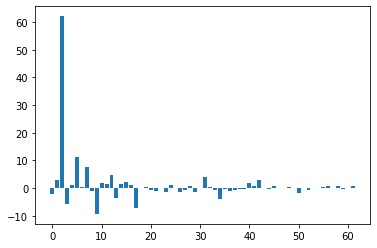

In [291]:
_ = plt.bar(range(0, len(alphabet)), averages)

In [292]:
r1 = np.median(deltas[:5 * n_queries] + deltas[6 * n_queries:]) - 1.5 * (np.quantile(deltas[:5 * n_queries] + deltas[6 * n_queries:], 0.9) - np.quantile(deltas[:5 * n_queries] + deltas[6 * n_queries:], 0.1)),\
np.median(deltas[:5 * n_queries] + deltas[6 * n_queries:]) + 1.5 * (np.quantile(deltas[:5 * n_queries] + deltas[6 * n_queries:], 0.9) - np.quantile(deltas[:5 * n_queries] + deltas[6 * n_queries:], 0.1))

In [293]:
r2 = np.median(deltas[5 * n_queries:6 * n_queries]) - 1.5 * (np.quantile(deltas[5 * n_queries:6 * n_queries], 0.9) - np.quantile(deltas[5 * n_queries:6 * n_queries], 0.1)),\
np.median(deltas[5 * n_queries:6 * n_queries]) + 1.5 * (np.quantile(deltas[5 * n_queries:6 * n_queries], 0.9) - np.quantile(deltas[5 * n_queries:6 * n_queries], 0.1))

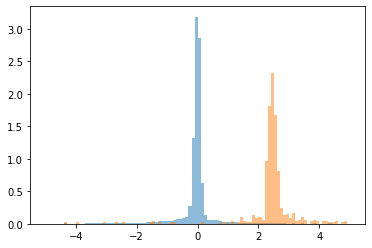

In [294]:
_ = plt.hist(deltas[:5 * n_queries] + deltas[6 * n_queries:], range=(-5,5), bins=100, alpha=0.5, density=True)
_ = plt.hist(deltas[5 * n_queries:6 * n_queries], range=(-5,5), bins=100, alpha=0.5, density=True)

In [295]:
r = np.median(deltas) - 1.5 * (np.quantile(deltas, 0.9) - np.quantile(deltas, 0.1)),\
np.median(deltas) + 1.5 * (np.quantile(deltas, 0.9) - np.quantile(deltas, 0.1))

In [296]:
gmm = GaussianMixture(n_components=2)

In [297]:
gmm.fit(np.array(deltas).reshape(-1, 1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [300]:
print(gmm.means_)
print(gmm.covariances_)
print(gmm.converged_)

[[1.42972354e-01]
 [2.98528800e+04]]
[[[3.78502614e+03]]

 [[1.00000000e-06]]]
True


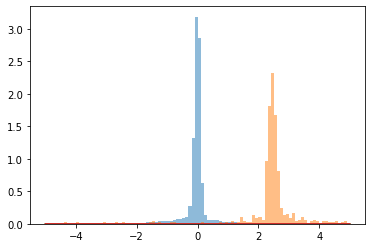

In [299]:
_ = plt.hist(deltas[:5 * n_queries] + deltas[6 * n_queries:], range=(-5, 5), bins=100, alpha=0.5, density=True)
_ = plt.hist(deltas[5 * n_queries:6 * n_queries], bins=100, range=(-5, 5), alpha=0.5, density=True)

xx = np.linspace(-5, 5, 100000)

_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[0,0], gmm.covariances_[0,0]))
_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[1,0], gmm.covariances_[1,0]))